---
### **Value at Risk (VaR) - The Parametric Method**
---

Importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

Setting the **time range** for a certain amount of years.

In [2]:
years     = 15
endDate   = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

Create a list of **ticker**.

In [3]:
# SPY := Largest S&P-500 ETF
# BND := Largest bond market ETF
# GLD := Largest commodity-based ETF that tracks the price of Gold
# QQQ := Largest Nasdaq ETF
# VTI := Vanguard's all-world stock index

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

For each of these tickers, we download the daily adjusted **close prices**.

NB: We use *adjusted close prices* rather than *normal* ones because *adjusted close prices* account for dividends stock splits and our analysis will be *more accurate* by incorporating those.

In [4]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Adj Close']

adj_close_df.head(n=5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-02-12,82.010902,51.598267,107.040001,38.222775,41.808720
2010-02-16,83.301376,51.663422,109.620003,38.711910,42.510998
2010-02-17,83.696083,51.546200,109.250000,38.930264,42.747646
2010-02-18,84.189484,51.474556,109.980003,39.174843,42.991920
2010-02-19,84.364059,51.474556,109.470001,39.157391,43.144585


Calculate the **daily log returns** and drop any NAs.

The **simple return** (or percentage change) is calculated as:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

where:
- $R_t$ is the return for day \( t \),
- $P_t$ is the price at day \( t \),
- $P_{t-1}$ is the price at the previous day.

The **log return** is defined as:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right)
$$

where $\ln$ represents the natural logarithm.

**Why Use Log Returns?** Logarithmic returns have an important property: **they are additive over time**.

For example, given two consecutive days' returns:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right), \quad r_{t+1} = \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Adding these two:

$$
r_t + r_{t+1} = \ln \left(\frac{P_t}{P_{t-1}}\right) + \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Using the logarithmic property:

$$
\ln a + \ln b = \ln (a \cdot b)
$$

we get:

$$
r_t + r_{t+1} = \ln \left(\frac{P_{t+1}}{P_{t-1}}\right)
$$

This means that log returns can be **directly summed over multiple periods**, making them convenient for time-series analysis, portfolio aggregation, and statistical modeling. In contrast, simple returns are **not additive** but must be compounded, making calculations more complex when dealing with multiple periods.


In [5]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

log_returns.head(n=5)

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-02-16,0.015613,0.001262,0.023817,0.012716,0.016658
2010-02-17,0.004727,-0.002272,-0.003381,0.005625,0.005551
2010-02-18,0.005878,-0.001391,0.006660,0.006263,0.005698
2010-02-19,0.002071,0.000000,-0.004648,-0.000446,0.003545
2010-02-22,0.000180,-0.000380,-0.003661,-0.002010,-0.001594


Create an **equally weighted portfolio**.

In [6]:
# Assume a portfolio value of $1M, equally weighted.
portfolio_value = 1000000
weights         = np.array([1 / len(tickers)] * len(tickers))

Calculate the **historical portfolio returns** based on our equally weighted portfolio.

In [7]:
historical_returns = (log_returns * weights).sum(axis=1)
historical_returns

Date
2010-02-16    0.014013
2010-02-17    0.002050
2010-02-18    0.004622
2010-02-19    0.000105
2010-02-22   -0.001493
                ...   
2025-02-03   -0.003178
2025-02-04    0.007460
2025-02-05    0.004896
2025-02-06    0.001477
2025-02-07   -0.006426
Length: 3770, dtype: float64

Find the X-days historical returns. We:
- Set a 5-day period.
- Create a DataFrame based on 5-days rolling returns.

We aim to compute the **rolling cumulative returns** over a specified period (**X days**), allowing us to analyze short-term return trends instead of just daily fluctuations.

We first calculate the **daily weighted portfolio returns**:

$$
\text{historical\returns} = \sum_{i=1}^{n} w_i \cdot r_i
$$

where:
- $w_i$ = portfolio weight of asset $i$,
- $r_i$ = daily log return of asset $i$,
- The sum is taken **across all assets** for each day.

To compute **X-day cumulative returns**, we use a **rolling sum** over the daily returns:

$$
R_t = \sum_{j=t-X+1}^{t} r_j
$$

where:
- $R_t$ is the **X-day cumulative return at time $t$**,
- $r_j$ are the **individual daily returns** in the rolling window,
- The window moves **day by day**, always summing the last X days.

**Why Use a Rolling Sum?**
- **Smooths out daily volatility** by aggregating past returns.
- **Reveals short-term trends** in portfolio performance.
- **Useful for risk and momentum analysis** in trading and investment strategies.

In [8]:
days = 5
historical_x_day_returns = historical_returns.rolling(window = days).sum()
historical_x_day_returns = historical_x_day_returns.dropna()

Create an <u>annualized</u> covariance matrix for all the securities.

The **covariance matrix** is a **square matrix** that contains the covariances between different assets in a portfolio. It helps measure how asset returns move together.

For a portfolio with **n** assets, the covariance matrix $\Sigma$ is an $n \times n$ matrix where the element at position $(i, j)$ represents the covariance between the returns of asset $i$ and asset $j$:

$$
\Sigma = 
\begin{bmatrix}
\sigma_{1,1} & \sigma_{1,2} & \dots & \sigma_{1,n} \\
\sigma_{2,1} & \sigma_{2,2} & \dots & \sigma_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n,1} & \sigma_{n,2} & \dots & \sigma_{n,n}
\end{bmatrix}
$$

where $\sigma_{i,j}$ is the covariance between asset $i$ and asset $j$, given by:

$$
\sigma_{i,j} = \text{Cov}(R_i, R_j) = \mathbb{E}[(R_i - \mu_i)(R_j - \mu_j)]
$$

- If $i = j$, then $\sigma_{i,j}$ represents the **variance** of asset $i$ $(\sigma^2_i)$.
- If $i \neq j$, then $\sigma_{i,j}$ represents the **covariance** between assets $i$ and $j$.

In [9]:
# There are 252 trading days in a year
cov_matrix = log_returns.cov() * 252
cov_matrix

,SPY,BND,GLD,QQQ,VTI
SPY,0.029141,0.000061,0.001258,0.032457,0.029754
BND,0.000061,0.002364,0.002295,0.000282,0.000112
GLD,0.001258,0.002295,0.023915,0.001594,0.001400
QQQ,0.032457,0.000282,0.001594,0.041910,0.033148
VTI,0.029754,0.000112,0.001400,0.033148,0.030627


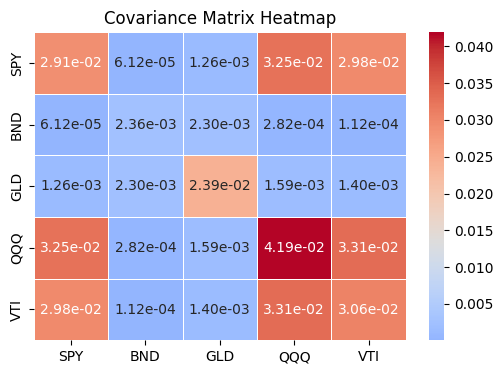

In [10]:
# Bonus: plotting the covariance matrix
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cov_matrix, annot=True, fmt=".2e", cmap="coolwarm", center=cov_matrix.values.mean(), linewidths=0.5)

plt.title("Covariance Matrix Heatmap")
plt.show()

Calculate **portfolio standard deviation**.

The standard deviation (volatility) of the portfolio can be computed as:

$$
\sigma_p = \sqrt{w^T \Sigma w}
$$

where $w$ is the weight vector and $\Sigma$ is the covariance matrix.

In [11]:
variance          = weights.T @ cov_matrix @ weights
portfolio_std_dev = np.sqrt(variance)

Set different **confidence levels** to visualize. 

In [12]:
confidence_levels = [0.9, 0.95, 0.99]

Calculate **VaR** for different confidence levels.

**Parametric (Variance-Covariance) Method**: This approach assumes that portfolio returns are **normally distributed**, allowing us to estimate VaR using the portfolio's **standard deviation** and a **Z-score** corresponding to the confidence level.

The **formula** for parametric VaR is:

$$
VaR = P_0 \cdot \sigma_p \cdot Z_{\alpha} \cdot \sqrt{\frac{T}{252}}
$$

where:
- $P_0$ = **portfolio value**
- $\sigma_p$ = **portfolio standard deviation**
- $Z_{\alpha}$ = **Z-score corresponding to the confidence level $\alpha$**
- $T$ = **time horizon (number of days)**
- **252** = Trading days in a year (used to annualize volatility)

**1. Portfolio Value $P_0$**: We express VaR in **monetary terms** by multiplying by $P_0$, since we want the final result to be a **dollar amount (or other currency)**.

**2. Volatility $\sigma_p$**: The standard deviation $\sigma_p$ tells us **how much the portfolio's returns fluctuate on average**. Higher volatility means **higher risk**, so it naturally **scales our risk estimate**.

**3. Scaling for Time Horizon $\frac{T}{252}$**: Volatility is **annualized**, meaning it represents **1 year of risk**. If we want VaR for $T$ days, we adjust using:

$$
\text{Volatility over T days} = \sigma_p \cdot \sqrt{\frac{T}{252}}
$$

This follows from the **square-root rule of time scaling**, which assumes **returns scale with the square root of time** (a property of **Brownian motion in finance**).

**4. Role of the Z-score $Z_{\alpha}$**
- This is the **critical piece** of the formula! The **Z-score tells us how extreme a loss is at a given confidence level**.
- The **standard normal distribution** $\mathcal{N}(0,1)$ represents **probability percentiles** (cf *Aparté* below).
- Multiplying by $Z_{\alpha}$ **scales the standard deviation to estimate worst-case losses at a given probability level**.

**Why Does This Give Us VaR?**
- **Volatility measures risk**, but alone it doesn't tell us **how bad losses can get**.
- **Z-score ensures we capture extreme losses**, not just **average fluctuations**.
- **Time scaling adjusts for multi-day horizons**.

Thus, this formula gives us the **worst expected loss over $T$ days at a given confidence level $\alpha$**, making it a **powerful risk metric**. Finally, this method provides a **quick and efficient estimate** of risk but assumes **normality of returns**, which may not always hold in real markets.

In [13]:
VaRs = []

for level in confidence_levels:
    VaR = portfolio_value * portfolio_std_dev * norm.ppf(level) * np.sqrt(days / 252)
    VaRs.append(VaR)

*Aparté*: What is `norm.ppf(level)`?

This function represents the **Percent-Point Function (PPF)**, also known as the **inverse cumulative distribution function (inverse CDF)** of the **standard normal distribution**. Mathematically, it is represented as:

$$
Z_{\alpha} = \Phi^{-1}(\alpha)
$$

where:
- $Z_{\alpha}$ is the **Z-score** corresponding to the confidence level $\alpha$,
- $\Phi^{-1}(\alpha)$ is the **inverse CDF of the standard normal distribution**.

For a **standard normal distribution** $\mathcal{N}(0,1)$, the CDF is:

$$
\Phi(Z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{Z} e^{-\frac{x^2}{2}} dx
$$

**Why Do We Use It?**
- `norm.ppf(level)` finds the **critical Z-score** for a given confidence level.
- Example values:
  - $\Phi^{-1}(0.90) \approx 1.28$ → 90% confidence
  - $\Phi^{-1}(0.95) \approx 1.64$ → 95% confidence
  - $\Phi^{-1}(0.99) \approx 2.33$ → 99% confidence

**⚠️ Not to confuse with:**  
- The **two-tailed** confidence intervals often used in hypothesis testing:  
  - A **90% two-tailed confidence interval** corresponds to $ Z = 1.64 $, $\Phi^{-1}(0.950)$, since 5% is in each tail.
  - A **95% two-tailed confidence interval** corresponds to $ Z = 1.96 $, $\Phi^{-1}(0.975)$.
  - A **99% two-tailed confidence interval** corresponds to $ Z = 2.58 $, $\Phi^{-1}(0.995)$

In **risk management (e.g., VaR calculations)**, we use **one-tailed Z-scores**, where we are interested in the **worst-case losses**, not the middle range of the distribution.

End of *aparté*.

Print out the **VaR results**.

In [14]:
# Print table headers
print(f'{"Confidence Level":<20} {"Value at Risk":<20}')
print('-' * 40)

# Print each confidence level and its corresponding VaR value
for level, VaR in zip(confidence_levels, VaRs):
    print(f'{level * 100:>6.0f}%: {"":<12} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:              $ 20,823.98
    95%:              $ 26,727.28
    99%:              $ 37,800.91


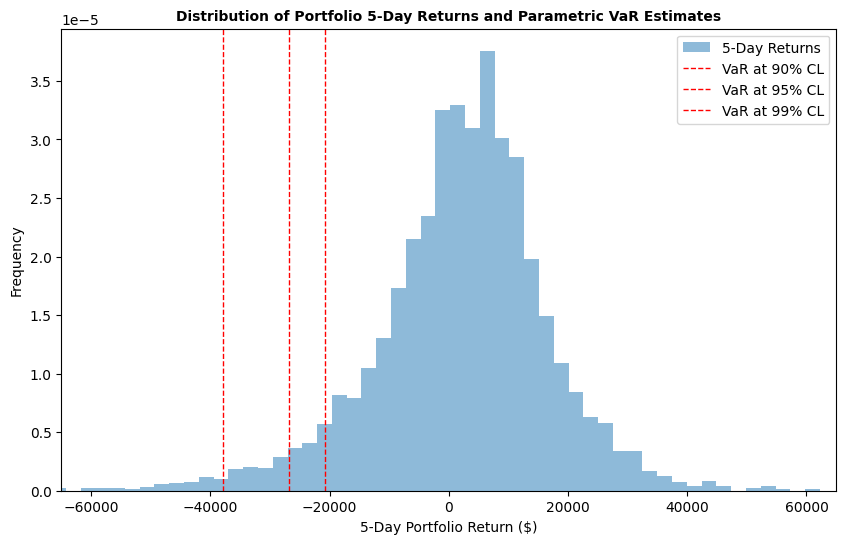

In [15]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=100, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add Value at Risk (VaR) line at each confidence level
for level, VaR in zip(confidence_levels, VaRs):
    plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=1, label=f'VaR at {int(level * 100)}% CL')

# Formatting labels and title
plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates', fontsize=10, fontweight='bold')

plt.xlim(left=-65000, right=65000)
plt.legend()
plt.show()

The histogram represents the **theoretical distribution of portfolio returns over 5 days** using the **parametric (variance-covariance) approach**. The **blue bars** show the **frequency of different gain/loss scenarios**, assuming a **normal distribution of returns** based on historical volatility. The **three red dashed lines** indicate the **Value at Risk (VaR) thresholds** at **90%, 95%, and 99% confidence levels**, representing the **worst expected losses under each probability level**. Unlike the Monte Carlo approach, which simulates returns, this method directly calculates risk using **portfolio standard deviation and Z-scores from the normal distribution**. This visualization helps assess **downside risk**, illustrating both **typical portfolio behavior** and the **potential for extreme losses based on statistical assumptions**.